In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Reading the merged raw data

df = pd.read_csv('/Users/sonalichaudhari/Desktop/Projects/Zillow/data/train_merged_data.csv',low_memory=False)
print(df.shape)
df.head()

(90275, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [3]:
X = df
y = df.pop("logerror")

In [4]:
# From the previous steps

In [ ]:
def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


class preprocessor:
    
    def __init__(self, cols_to_filter=None, datecols=None):
        
        self.cols_to_filter = cols_to_filter
        self.datecols = datecols
        self.was_fit = False
    
    def fit(self, X, y=None):
        """learn any information from the training data we may need to transform the test data"""
        
        self.was_fit = True
        
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)
        
        categorical_features = X_new.dtypes[X_new.dtypes == 'object'].index
        self.categorical_features = [x for x in categorical_features if 'date' not in x]
        
        dummied = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        self.colnames = dummied.columns
        del dummied
        
        return self
    
    def transform(self, X, y=None):
        """transform the training or test data"""
        # transform the training or test data based on class attributes learned in the `fit` step
        
        if not self.was_fit:
            raise Error("need to fit preprocessor first")
        
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)

        # dummy code
        X_new = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        newcols = set(self.colnames) - set(X_new.columns)

        for x in newcols:
            X_new[x] = 0
            
        X_new = X_new[self.colnames]
                
        # fill NA after we dummy code
        X_new = X_new.fillna(-1)
        
        if self.datecols:
            for x in self.datecols:
                X_new[x + '_month'] = pd.to_datetime(X_new[x]).apply(lambda x: x.month)
                X_new[x + '_year'] = pd.to_datetime(X_new[x]).apply(lambda x: x.year)
                X_new = X_new.drop(x, axis=1)
        
        return X_new
    
    def fit_transform(self, X, y=None):
        """fit and transform wrapper method, used for sklearn pipeline"""

        return self.fit(X).transform(X)

In [6]:
# use our preprocessor on the training data
p=preprocessor(cols_to_filter = ['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc', 
                                 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])

X = p.fit_transform(X)

In [7]:
X.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,propertycountylandusecode_73,propertycountylandusecode_8800,propertycountylandusecode_96,propertycountylandusecode_nan,fireplaceflag_True,fireplaceflag_nan,taxdelinquencyflag_Y,taxdelinquencyflag_nan,transactiondate_month,transactiondate_year
0,1.0,-1.0,-1.0,2.0,3.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
1,-1.0,-1.0,-1.0,3.5,4.0,-1.0,-1.0,3.5,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
2,1.0,-1.0,-1.0,3.0,2.0,-1.0,4.0,3.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
3,1.0,-1.0,-1.0,2.0,2.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
4,-1.0,-1.0,-1.0,2.5,4.0,-1.0,-1.0,2.5,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016


## Parameter Tuning and Model Selection¶

## 1. RANDOM FOREST

In [54]:
#random_forest_params(X,y)

In [14]:
X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
# Create a based model
rf = RandomForestRegressor(n_estimators=20,max_depth=30, min_samples_split= 8)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
y_pred = rf.predict(X_tune)

In [16]:
mean_abs_error(y_pred, y_tune)

0.07226114655104504

In [11]:
r = RandomForestRegressor()

In [19]:
r.fit(X_train,y_train)
y_pred=r.predict(X_tune)
mean_abs_error(y_pred, y_tune)

0.08193020751899655

In [20]:
X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
# Create a based model
rt = RandomForestRegressor(n_estimators=20)
rt.fit(X_train, y_train)
y_pred = rt.predict(X_tune)
mean_abs_error(y_pred, y_tune)

0.07756920099217682

In [21]:
X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
# Create a based model
rt = RandomForestRegressor(max_depth=30)
rt.fit(X_train, y_train)
y_pred = rt.predict(X_tune)
mean_abs_error(y_pred, y_tune)

0.07539895109586513

In [22]:
X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
# Create a based model
rt = RandomForestRegressor(min_samples_split= 8)
rt.fit(X_train, y_train)
y_pred = rt.predict(X_tune)
mean_abs_error(y_pred, y_tune)

0.07897855438013178

In [23]:
X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
# Create a based model
rt = RandomForestRegressor(n_estimators=50,max_depth=50, min_samples_split= 12)
rt.fit(X_train, y_train)
y_pred = rt.predict(X_tune)
mean_abs_error(y_pred, y_tune)

0.07225309383123198

In [24]:
X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
# Create a based model
rt = RandomForestRegressor(n_estimators=65,max_depth=50, min_samples_split= 15)
rt.fit(X_train, y_train)
y_pred = rt.predict(X_tune)
mean_abs_error(y_pred, y_tune)

0.07176042269531917

In [26]:
def random_forest_params(X,y):
    param_grid = {
    'max_depth': [20, 30, 40, 50],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [20, 30, 40, 50, 55, 60, 65, 75, 80]
    }
    X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
    
    # Fitting the data
    grid_search.fit(X_train, y_train)
    
    # Best parameters
    best_grid = grid_search.best_estimator_
    
    grid_accuracy = evaluate(best_grid, X_tune, y_tune)
    print(grid_accuracy)

In [ ]:
random_forest_params(X,y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=30, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=30, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=30, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=40, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=40, max_depth=20, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=3, total=  24.1s
[CV]  min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=3, total=  24.0s
[CV] min_samples_split=8, n_estimators=40, max_depth=20, min_samples_leaf=3 
[CV] min_samples_split=8, n_estimators=50, max_depth=20, min

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min


[CV]  min_samples_split=8, n_estimators=75, max_depth=20, min_samples_leaf=3, total= 1.5min
[CV] min_samples_split=10, n_estimators=40, max_depth=20, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=20, max_depth=20, min_samples_leaf=3, total=  24.8s
[CV] min_samples_split=10, n_estimators=40, max_depth=20, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=30, max_depth=20, min_samples_leaf=3, total=  38.1s
[CV] min_samples_split=10, n_estimators=40, max_depth=20, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=30, max_depth=20, min_samples_leaf=3, total=  36.7s
[CV] min_samples_split=10, n_estimators=50, max_depth=20, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=30, max_depth=20, min_samples_leaf=3, total=  37.6s
[CV] min_samples_split=10, n_estimators=50, max_depth=20, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=80, max_depth=20, min_samples_leaf=3, total= 1.7min
[CV] min_samples_split=10, n_estimators=50, max_depth=

[CV]  min_samples_split=12, n_estimators=65, max_depth=20, min_samples_leaf=3, total= 1.5min
[CV] min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=65, max_depth=20, min_samples_leaf=3, total= 1.5min
[CV] min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=4, total=  28.9s
[CV] min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=75, max_depth=20, min_samples_leaf=3, total= 1.7min
[CV] min_samples_split=8, n_estimators=30, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=75, max_depth=20, min_samples_leaf=3, total= 1.7min
[CV] min_samples_split=8, n_estimators=30, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=20, max_depth=20, min_samples_leaf=4, total=  28.0s
[CV] min_samples_split=8, n_estimators=30, max_depth=20, mi

[CV] min_samples_split=10, n_estimators=75, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=55, max_depth=20, min_samples_leaf=4, total= 1.5min
[CV] min_samples_split=10, n_estimators=75, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=60, max_depth=20, min_samples_leaf=4, total= 1.7min
[CV] min_samples_split=10, n_estimators=75, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=60, max_depth=20, min_samples_leaf=4, total= 1.5min
[CV] min_samples_split=10, n_estimators=80, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=60, max_depth=20, min_samples_leaf=4, total= 1.4min
[CV] min_samples_split=10, n_estimators=80, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=65, max_depth=20, min_samples_leaf=4, total= 1.6min
[CV] min_samples_split=10, n_estimators=80, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=65, max_depth=20, min_samp

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 21.5min


[CV]  min_samples_split=12, n_estimators=50, max_depth=20, min_samples_leaf=4, total= 1.1min
[CV] min_samples_split=12, n_estimators=65, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=20, min_samples_leaf=4, total= 1.2min
[CV] min_samples_split=12, n_estimators=65, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=20, min_samples_leaf=4, total= 1.2min
[CV] min_samples_split=12, n_estimators=75, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=20, min_samples_leaf=4, total= 1.2min
[CV] min_samples_split=12, n_estimators=75, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=60, max_depth=20, min_samples_leaf=4, total= 1.3min
[CV] min_samples_split=12, n_estimators=75, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=60, max_depth=20, min_samples_leaf=4, total= 1.3min
[CV] min_samples_split=12, n_estimators=80, max_dept

[CV] min_samples_split=10, n_estimators=55, max_depth=20, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=40, max_depth=20, min_samples_leaf=5, total=  51.5s
[CV] min_samples_split=10, n_estimators=55, max_depth=20, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=40, max_depth=20, min_samples_leaf=5, total=  50.4s
[CV] min_samples_split=10, n_estimators=60, max_depth=20, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=40, max_depth=20, min_samples_leaf=5, total=  49.7s
[CV] min_samples_split=10, n_estimators=60, max_depth=20, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=50, max_depth=20, min_samples_leaf=5, total= 1.1min
[CV] min_samples_split=10, n_estimators=60, max_depth=20, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=50, max_depth=20, min_samples_leaf=5, total= 1.0min
[CV] min_samples_split=10, n_estimators=65, max_depth=20, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=50, max_depth=20, min_samp

[CV] min_samples_split=8, n_estimators=40, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=80, max_depth=20, min_samples_leaf=5, total= 1.9min
[CV] min_samples_split=8, n_estimators=40, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=30, max_depth=30, min_samples_leaf=3, total=  58.3s
[CV] min_samples_split=8, n_estimators=50, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=30, max_depth=30, min_samples_leaf=3, total=  59.0s
[CV] min_samples_split=8, n_estimators=50, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=80, max_depth=20, min_samples_leaf=5, total= 1.9min
[CV] min_samples_split=8, n_estimators=50, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=30, max_depth=30, min_samples_leaf=3, total=  56.7s
[CV] min_samples_split=8, n_estimators=55, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=80, max_depth=20, min_samples_leaf=

[CV]  min_samples_split=12, n_estimators=20, max_depth=30, min_samples_leaf=3, total=  37.3s
[CV] min_samples_split=12, n_estimators=20, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=75, max_depth=30, min_samples_leaf=3, total= 2.2min
[CV] min_samples_split=12, n_estimators=30, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=75, max_depth=30, min_samples_leaf=3, total= 2.3min
[CV] min_samples_split=12, n_estimators=30, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=20, max_depth=30, min_samples_leaf=3, total=  34.1s
[CV] min_samples_split=12, n_estimators=30, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=20, max_depth=30, min_samples_leaf=3, total=  34.2s
[CV] min_samples_split=12, n_estimators=40, max_depth=30, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=75, max_depth=30, min_samples_leaf=3, total= 2.2min
[CV] min_samples_split=12, n_estimators=40, max_dept

[CV] min_samples_split=8, n_estimators=75, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=60, max_depth=30, min_samples_leaf=4, total= 1.6min
[CV] min_samples_split=8, n_estimators=80, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=60, max_depth=30, min_samples_leaf=4, total= 1.5min
[CV] min_samples_split=8, n_estimators=80, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=65, max_depth=30, min_samples_leaf=4, total= 1.7min
[CV] min_samples_split=8, n_estimators=80, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=65, max_depth=30, min_samples_leaf=4, total= 1.7min
[CV] min_samples_split=10, n_estimators=20, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=65, max_depth=30, min_samples_leaf=4, total= 1.6min
[CV] min_samples_split=10, n_estimators=20, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=20, max_depth=30, min_samples_leaf=

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 57.2min


[CV]  min_samples_split=8, n_estimators=75, max_depth=30, min_samples_leaf=4, total= 1.9min
[CV]  min_samples_split=10, n_estimators=20, max_depth=30, min_samples_leaf=4, total=  30.5s
[CV] min_samples_split=10, n_estimators=40, max_depth=30, min_samples_leaf=4 
[CV] min_samples_split=10, n_estimators=40, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=80, max_depth=30, min_samples_leaf=4, total=22.2min
[CV] min_samples_split=10, n_estimators=40, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=30, max_depth=30, min_samples_leaf=4, total=20.8min
[CV] min_samples_split=10, n_estimators=50, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=30, max_depth=30, min_samples_leaf=4, total=20.9min
[CV] min_samples_split=10, n_estimators=50, max_depth=30, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=30, max_depth=30, min_samples_leaf=4, total=20.8min
[CV] min_samples_split=10, n_estimators=50, max_depth=

[CV]  min_samples_split=12, n_estimators=65, max_depth=30, min_samples_leaf=4, total= 1.8min
[CV] min_samples_split=8, n_estimators=20, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=12, n_estimators=65, max_depth=30, min_samples_leaf=4, total= 1.8min
[CV] min_samples_split=8, n_estimators=20, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=8, n_estimators=20, max_depth=30, min_samples_leaf=5, total=  35.1s
[CV] min_samples_split=8, n_estimators=20, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=12, n_estimators=75, max_depth=30, min_samples_leaf=4, total= 2.1min
[CV] min_samples_split=8, n_estimators=30, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=12, n_estimators=75, max_depth=30, min_samples_leaf=4, total= 2.2min
[CV] min_samples_split=8, n_estimators=30, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=8, n_estimators=20, max_depth=30, min_samples_leaf=5, total=  33.4s
[CV] min_samples_split=8, n_estimators=30, max_depth=30, mi

[CV] min_samples_split=10, n_estimators=75, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=55, max_depth=30, min_samples_leaf=5, total= 1.4min
[CV] min_samples_split=10, n_estimators=75, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=60, max_depth=30, min_samples_leaf=5, total= 1.6min
[CV] min_samples_split=10, n_estimators=75, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=60, max_depth=30, min_samples_leaf=5, total= 1.5min
[CV] min_samples_split=10, n_estimators=80, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=60, max_depth=30, min_samples_leaf=5, total= 1.5min
[CV] min_samples_split=10, n_estimators=80, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=65, max_depth=30, min_samples_leaf=5, total= 1.7min
[CV] min_samples_split=10, n_estimators=80, max_depth=30, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=65, max_depth=30, min_samp

[CV]  min_samples_split=8, n_estimators=40, max_depth=40, min_samples_leaf=3, total= 1.2min
[CV] min_samples_split=8, n_estimators=60, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=50, max_depth=40, min_samples_leaf=3, total= 1.5min
[CV] min_samples_split=8, n_estimators=60, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=50, max_depth=40, min_samples_leaf=3, total= 1.6min
[CV] min_samples_split=8, n_estimators=65, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=50, max_depth=40, min_samples_leaf=3, total= 1.5min
[CV] min_samples_split=8, n_estimators=65, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=55, max_depth=40, min_samples_leaf=3, total= 1.8min
[CV] min_samples_split=8, n_estimators=65, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=55, max_depth=40, min_samples_leaf=3, total= 1.7min
[CV] min_samples_split=8, n_estimators=75, max_depth=40, min_sa

[CV] min_samples_split=12, n_estimators=50, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=30, max_depth=40, min_samples_leaf=3, total=  55.6s
[CV] min_samples_split=12, n_estimators=50, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=80, max_depth=40, min_samples_leaf=3, total= 2.6min
[CV] min_samples_split=12, n_estimators=55, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=80, max_depth=40, min_samples_leaf=3, total= 2.5min
[CV] min_samples_split=12, n_estimators=55, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=40, max_depth=40, min_samples_leaf=3, total= 1.3min
[CV] min_samples_split=12, n_estimators=55, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=40, max_depth=40, min_samples_leaf=3, total= 1.3min
[CV] min_samples_split=12, n_estimators=60, max_depth=40, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=40, max_depth=40, min_samp

[CV]  min_samples_split=10, n_estimators=20, max_depth=40, min_samples_leaf=4, total=  36.3s
[CV] min_samples_split=10, n_estimators=30, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=75, max_depth=40, min_samples_leaf=4, total= 2.2min
[CV] min_samples_split=10, n_estimators=40, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=20, max_depth=40, min_samples_leaf=4, total=  36.3s
[CV] min_samples_split=10, n_estimators=40, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=80, max_depth=40, min_samples_leaf=4, total= 2.5min
[CV]  min_samples_split=10, n_estimators=30, max_depth=40, min_samples_leaf=4, total=  58.1s
[CV] min_samples_split=10, n_estimators=40, max_depth=40, min_samples_leaf=4 
[CV] min_samples_split=10, n_estimators=50, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=30, max_depth=40, min_samples_leaf=4, total=  56.9s
[CV] min_samples_split=10, n_estimators=50, max_depth=

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 131.6min


[CV]  min_samples_split=12, n_estimators=50, max_depth=40, min_samples_leaf=4, total= 1.5min
[CV] min_samples_split=12, n_estimators=65, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=40, min_samples_leaf=4, total= 1.7min
[CV] min_samples_split=12, n_estimators=65, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=40, min_samples_leaf=4, total= 1.6min
[CV] min_samples_split=12, n_estimators=75, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=40, min_samples_leaf=4, total= 1.7min
[CV] min_samples_split=12, n_estimators=75, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=60, max_depth=40, min_samples_leaf=4, total= 1.9min
[CV] min_samples_split=12, n_estimators=75, max_depth=40, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=60, max_depth=40, min_samples_leaf=4, total= 1.9min
[CV] min_samples_split=12, n_estimators=80, max_dept

[CV] min_samples_split=10, n_estimators=55, max_depth=40, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=40, max_depth=40, min_samples_leaf=5, total= 1.3min
[CV] min_samples_split=10, n_estimators=55, max_depth=40, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=40, max_depth=40, min_samples_leaf=5, total= 1.3min
[CV] min_samples_split=10, n_estimators=60, max_depth=40, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=40, max_depth=40, min_samples_leaf=5, total= 1.2min
[CV] min_samples_split=10, n_estimators=60, max_depth=40, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=50, max_depth=40, min_samples_leaf=5, total= 1.4min
[CV] min_samples_split=10, n_estimators=60, max_depth=40, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=50, max_depth=40, min_samples_leaf=5, total= 1.5min
[CV] min_samples_split=10, n_estimators=65, max_depth=40, min_samples_leaf=5 
[CV]  min_samples_split=10, n_estimators=50, max_depth=40, min_samp

[CV] min_samples_split=8, n_estimators=40, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=30, max_depth=50, min_samples_leaf=3, total=  59.5s
[CV] min_samples_split=8, n_estimators=40, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=80, max_depth=40, min_samples_leaf=5, total= 2.5min
[CV] min_samples_split=8, n_estimators=50, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=30, max_depth=50, min_samples_leaf=3, total= 1.1min
[CV] min_samples_split=8, n_estimators=50, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=8, n_estimators=30, max_depth=50, min_samples_leaf=3, total=  59.1s
[CV] min_samples_split=8, n_estimators=50, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=80, max_depth=40, min_samples_leaf=5, total= 2.4min
[CV] min_samples_split=8, n_estimators=55, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=80, max_depth=40, min_samples_leaf=

[CV]  min_samples_split=12, n_estimators=20, max_depth=50, min_samples_leaf=3, total=  43.4s
[CV] min_samples_split=12, n_estimators=20, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=75, max_depth=50, min_samples_leaf=3, total= 2.6min
[CV] min_samples_split=12, n_estimators=30, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=75, max_depth=50, min_samples_leaf=3, total= 2.7min
[CV] min_samples_split=12, n_estimators=30, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=20, max_depth=50, min_samples_leaf=3, total=  41.8s
[CV] min_samples_split=12, n_estimators=30, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=10, n_estimators=75, max_depth=50, min_samples_leaf=3, total= 2.5min
[CV] min_samples_split=12, n_estimators=40, max_depth=50, min_samples_leaf=3 
[CV]  min_samples_split=12, n_estimators=20, max_depth=50, min_samples_leaf=3, total=  40.7s
[CV] min_samples_split=12, n_estimators=40, max_dept

[CV] min_samples_split=8, n_estimators=75, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=60, max_depth=50, min_samples_leaf=4, total= 1.9min
[CV] min_samples_split=8, n_estimators=80, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=60, max_depth=50, min_samples_leaf=4, total= 1.8min
[CV] min_samples_split=8, n_estimators=80, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=65, max_depth=50, min_samples_leaf=4, total= 2.0min
[CV] min_samples_split=8, n_estimators=80, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=65, max_depth=50, min_samples_leaf=4, total= 2.1min
[CV] min_samples_split=10, n_estimators=20, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=8, n_estimators=65, max_depth=50, min_samples_leaf=4, total= 2.0min
[CV] min_samples_split=10, n_estimators=20, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=10, n_estimators=20, max_depth=50, min_samples_leaf=

[CV] min_samples_split=12, n_estimators=60, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=50, max_depth=50, min_samples_leaf=4, total= 1.5min
[CV] min_samples_split=12, n_estimators=65, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=50, max_depth=50, min_samples_leaf=4, total= 1.5min
[CV] min_samples_split=12, n_estimators=65, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=50, min_samples_leaf=4, total= 1.7min
[CV] min_samples_split=12, n_estimators=65, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=50, min_samples_leaf=4, total= 1.6min
[CV] min_samples_split=12, n_estimators=75, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=55, max_depth=50, min_samples_leaf=4, total= 1.6min
[CV] min_samples_split=12, n_estimators=75, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=12, n_estimators=60, max_depth=50, min_samp

## 2. GBM

In [14]:
def gbm_select_params(X, y, max_estimators=1000, max_depth = 3, learning_rate=0.01):
    X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
    
    gbm = GradientBoostingRegressor(n_estimators = max_estimators, learning_rate=learning_rate, 
                                    max_depth=max_depth, loss='lad', subsample=0.5)

    gbm.fit(X_train, y_train)

    test_score = np.zeros((max_estimators,), dtype=np.float64)

    for i, y_pred in enumerate(gbm.staged_predict(X_tune)):
        test_score[i] = mean_abs_error(y_tune, y_pred)
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best MAE: {0}'.format(test_score.min()))
    print('baseline MAE: {0}'.format(mean_abs_error(y_tune, y_train.median())))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

#### Tune Tree Depth
learning_rate and max_estimators are anticorrelated; the higher the learning rate the fewer trees are needed. Thus, cranking up the learning rate will make your models fit faster. This comes with a bit of an accuracy hit though, so one popular technique is to tune the tree depth with a higher learning rate and then tune the number of trees with a lower learning rate.

***** training for max depth = 2 *****
optimal number of trees: 754
best MAE: 0.06699972211501322
baseline MAE: 0.06783881373569056


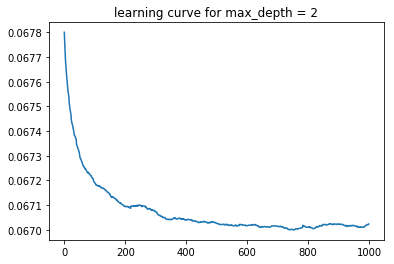

***** training for max depth = 3 *****
optimal number of trees: 387
best MAE: 0.06700549461692479
baseline MAE: 0.06783881373569056


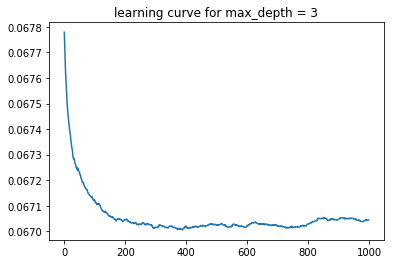

***** training for max depth = 4 *****
optimal number of trees: 267
best MAE: 0.06700745229438655
baseline MAE: 0.06783881373569056


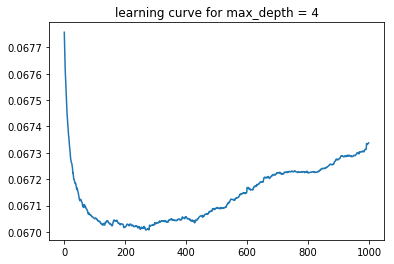

In [15]:
for depth in [2, 3, 4]:
    print('***** training for max depth = {0} *****'.format(depth))
    gbm_select_params(X, y, max_estimators=1000, max_depth=depth, learning_rate=0.1)

### LINEAR REGRESSION

In [ ]:
def